In [37]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [38]:
class Agent:
    def __init__(self, id):
        self.id = id
        self.payoff = 0
        self.memory = {}   # partner_id -> trust value (0–1)

    def choose_action(self, partner_id):
        """Decide to cooperate or defect based on trust."""
        trust = self.memory.get(partner_id, 0.5)  # Default neutral trust
        return "S" if random.random() < trust else "D"

    def update_trust(self, partner_id, partner_action):
        """Simple reinforcement learning rule for trust."""
        trust = self.memory.get(partner_id, 0.5)
        if partner_action == "S":
            trust += 0.1 * (1 - trust)    # reward good behavior
        else:
            trust -= 0.1 * trust          # punish defection
        self.memory[partner_id] = np.clip(trust, 0, 1)


In [39]:
def create_network(num_agents=50, connection_prob=0.1):
    """Generate a random network (Erdos–Renyi model)."""
    G = nx.erdos_renyi_graph(num_agents, connection_prob)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
    return G

In [40]:
#Defining the payoff matrix
payoff = {
    ("S","S"):(4,4),
    ("S","D"):(0,6),
    ("D","S"):(6,0),
    ("D","D"):(1,1)
}

In [41]:
#Runing the world
def run_network_simulation(num_agents=50, rounds=200, connection_prob=0.1):
    G = create_network(num_agents, connection_prob)

    agents = {i: Agent(i) for i in G.nodes()}
    log = []

    for r in range(rounds):
        for a_id, a in agents.items():
            neighbors = list(G.neighbors(a_id))
            if not neighbors:
                continue
            b_id = random.choice(neighbors)
            b = agents[b_id]

            act_a = a.choose_action(b.id)
            act_b = b.choose_action(a.id)
            pay_a, pay_b = payoff[(act_a, act_b)]
            a.payoff += pay_a
            b.payoff += pay_b
            a.update_trust(b.id, act_b)
            b.update_trust(a.id, act_a)
            log.append((r, a.id, b.id, act_a, act_b, pay_a, pay_b))

    df = pd.DataFrame(log, columns=["round","A","B","A_act","B_act","A_pay","B_pay"])
    return list(agents.values()), df, G



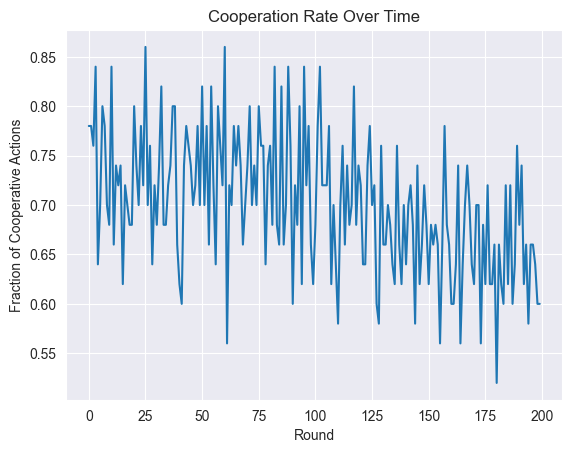

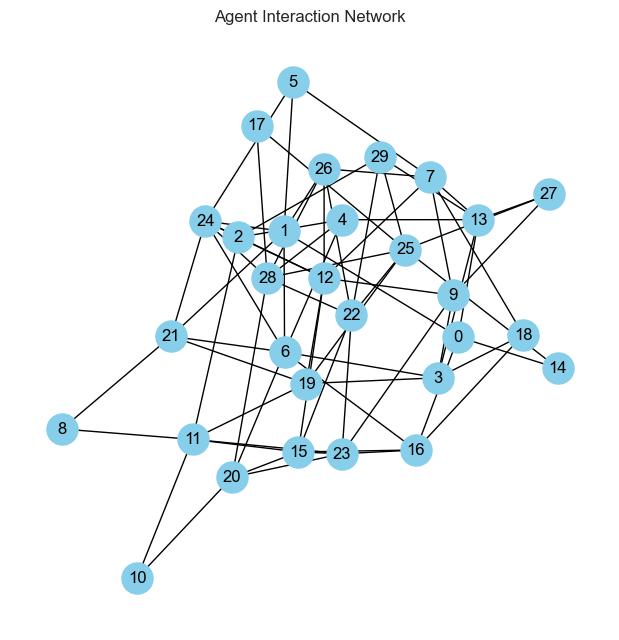

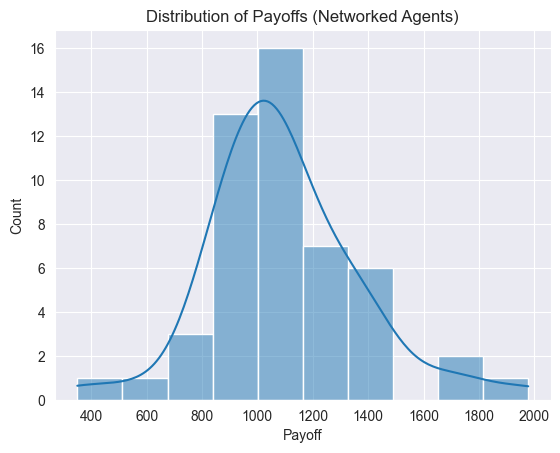

          Agent       Payoff
count  50.00000    50.000000
mean   24.50000  1096.360000
std    14.57738   276.640027
min     0.00000   350.000000
25%    12.25000   926.750000
50%    24.50000  1058.000000
75%    36.75000  1235.750000
max    49.00000  1978.000000


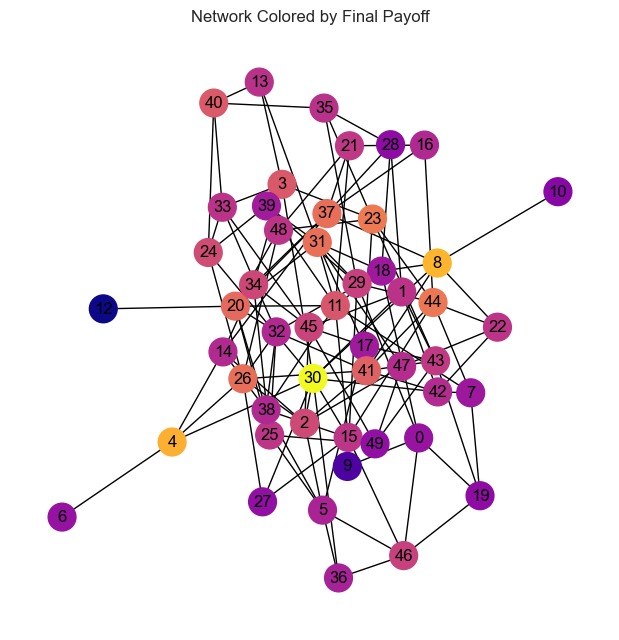


Information Sharing Simulation
Author: Qudus Bawa-Allah


In [42]:
agents, df, G = run_network_simulation()

coop_rate = []
for r in range(df["round"].max()+1):
    sub = df[df["round"] == r]
    coop_rate.append(((sub["A_act"] == "S") | (sub["B_act"] == "S")).mean())

plt.plot(coop_rate)
plt.title("Cooperation Rate Over Time")
plt.xlabel("Round")
plt.ylabel("Fraction of Cooperative Actions")
plt.show()

G = create_network(30, 0.15)
plt.figure(figsize=(6,6))
nx.draw(G, node_color="skyblue", node_size=500, with_labels=True)
plt.title("Agent Interaction Network")
plt.show()

agents, df, G = run_network_simulation(num_agents=50, rounds=200, connection_prob=0.1)

summary = pd.DataFrame({
    "Agent": [a.id for a in agents],
    "Payoff": [a.payoff for a in agents],
})

sns.histplot(summary["Payoff"], kde=True)
plt.title("Distribution of Payoffs (Networked Agents)")
plt.xlabel("Payoff")
plt.show()

print(summary.describe())

plt.figure(figsize=(6,6))
node_colors = [a.payoff for a in agents]
nx.draw(G, node_color=node_colors, cmap=plt.cm.plasma, node_size=400, with_labels=True)
plt.title("Network Colored by Final Payoff")
plt.show()

print("""
Information Sharing Simulation
Author: Qudus Bawa-Allah""")